In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from pathlib import Path
import os, PIL, mimetypes
from typing import *
from functools import partial

In [4]:
#export
imagenette_path=Path(r'd:\git\dl\data\imagenette_160')
Path.ls=lambda x: list(x.iterdir())

In [5]:
imagenette_path.ls()

[WindowsPath('d:/git/dl/data/imagenette_160/train'),
 WindowsPath('d:/git/dl/data/imagenette_160/val')]

In [5]:
(img_path.joinpath('train')).ls()[0].ls()[:15]

[WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10026.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10027.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10029.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10040.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10042.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10043.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10048.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10066.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10074.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_1009.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10095.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10108.J

In [6]:
path_tench=(img_path.joinpath('train')).ls()[0]

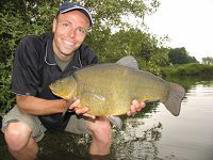

In [9]:
img=PIL.Image.open((imagenette_path.joinpath('train')).ls()[0].ls()[1])
img

In [10]:
#export
import matplotlib.pyplot as plt

def mpl_plotimg(img):
    return plt.imshow(img)

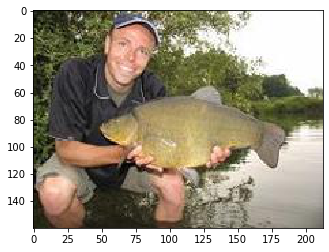

In [12]:
mpl_plotimg(img)

In [9]:
#export
img_extensions={k for k,v in mimetypes.types_map.items() if v.startswith('image')}

In [10]:
#export
def listify(obj):
    if obj is None: return []
    if isinstance(obj, list): return obj
    if isinstance(obj, str): return [obj]
    if isinstance(obj, Iterable): return list(obj)
    return [obj]

In [11]:
#export
def setify(obj): return obj if isinstance(obj, set) else set(listify(obj))

In [12]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [13]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(img_path, t, extensions=img_extensions)
t[:3]

[WindowsPath('d:/git/dl/data/imagenette_160/n01440764_10026.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/n01440764_10027.JPEG'),
 WindowsPath('d:/git/dl/data/imagenette_160/n01440764_10029.JPEG')]

In [14]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [15]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [16]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = img_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

In [17]:
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [18]:
il = ImageList.from_files(img_path, tfms=make_rgb)

In [20]:
il

ImageList (13394 items)
[WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10026.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10027.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10029.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10040.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10042.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10043.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10048.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10066.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10074.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_1009.JPEG')...]
Path: d:\git\dl\data\imagenette_160

In [21]:
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f,t

In [24]:
splitter = partial(grandparent_splitter, valid_name='val')

In [25]:
%time train,valid = split_by_func(il, splitter)

Wall time: 89.3 ms


In [26]:
len(train),len(valid)

(12894, 500)

In [27]:
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [28]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (12894 items)
[WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10026.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10027.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10029.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10040.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10042.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10043.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10048.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10066.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10074.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_1009.JPEG')...]
Path: d:\git\dl\data\imagenette_160
Valid: ImageList (500 items)
[WindowsPath('d:/git/dl/data/imagenette_160/val/n01440764/ILS

In [29]:
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [30]:
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

In [31]:
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [32]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [33]:
assert ll.train.proc_y is ll.valid.proc_y

In [34]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: d:\git\dl\data\imagenette_160

In [35]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10026.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10027.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10029.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10040.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10042.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10043.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10048.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10066.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_10074.JPEG'), WindowsPath('d:/git/dl/data/imagenette_160/train/n01440764/n01440764_1009.JPEG')...]
Path: d:\git\dl\data\imagenette_160
y: ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: d:\git\dl

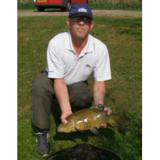

In [36]:
ll.train[0][0]

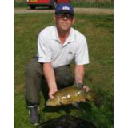

In [37]:
ll.train[0][0].resize((128,128))

In [38]:
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30